
# No Smoke Max Fall Isopleth with Photon Flux

This notebook loads the No Smoke Max Fall dataset, enriches each sample with photon flux data from the Synoptic/MesoWest API (station `QHW` – Hawthorne), and renders an ozone isopleth with data points colored by how far their photon flux deviates from the seasonal mean.


In [35]:
import os
from pathlib import Path
from datetime import timedelta

import numpy as np
import pandas as pd
import requests

import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns
from scipy.interpolate import LSQBivariateSpline

plt.style.use('seaborn-v0_8')
sns.set_context('talk')
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

MESOWEST_TOKEN = os.getenv("MESOWEST_TOKEN")
if not MESOWEST_TOKEN:
    raise ValueError('Please set the MESOWEST_TOKEN environment variable before running this notebook.')

STATION_ID = 'QHW'  # Hawthorne

In [36]:
data_path = Path('../data/utah/nosmoke/No_Smoke_Max_Fall.csv')
no_smoke_df = pd.read_csv(data_path, parse_dates=['dt'])
no_smoke_df.sort_values('dt', inplace=True)
no_smoke_df['dt_hour'] = no_smoke_df['dt'].dt.floor('H')

print(f"Loaded {len(no_smoke_df)} observations spanning {no_smoke_df['dt'].min()} to {no_smoke_df['dt'].max()}.")
no_smoke_df.head()

Loaded 162 observations spanning 2021-09-01 15:00:00 to 2023-09-30 10:00:00.


,NOx,VOC,Ozone,dt,dt_hour
0,4.3,14.1395,80.0,2021-09-01 15:00:00,2021-09-01 15:00:00
1,5.2,27.2669,58.0,2021-09-10 16:00:00,2021-09-10 16:00:00
2,3.2,21.5934,63.0,2021-09-25 15:00:00,2021-09-25 15:00:00
3,3.3,28.0155,64.0,2021-09-26 14:00:00,2021-09-26 14:00:00
4,4.2,27.8623,41.0,2021-09-28 17:00:00,2021-09-28 17:00:00


In [37]:
TIMEZONE = 'America/Denver'
BASE_URL = 'https://api.synopticdata.com/v2/stations/timeseries'


def fetch_synoptic_series(token: str, station: str, start, end, variable: str = 'solar_radiation', obtimezone: str = 'local') -> pd.Series:
    """Fetch hourly observations for a Synoptic/MesoWest station."""
    params = {
        'token': token,
        'stid': station,
        'start': start.strftime('%Y%m%d%H%M'),
        'end': end.strftime('%Y%m%d%H%M'),
        'vars': variable,
        'obtimezone': obtimezone,
        'output': 'json'
    }
    response = requests.get(BASE_URL, params=params, timeout=30)
    response.raise_for_status()
    payload = response.json()
    summary = payload.get('SUMMARY', {})
    if summary.get('RESPONSE_CODE') != 1 or not payload.get('STATION'):
        raise RuntimeError(f"Synoptic request failed: {summary.get('RESPONSE_MESSAGE')}")

    observations = payload['STATION'][0]['OBSERVATIONS']
    timestamps = pd.to_datetime(observations['date_time'], utc=True)
    local_index = timestamps.tz_convert(TIMEZONE).tz_localize(None)
    values = pd.Series(observations[f'{variable}_set_1'], index=local_index, dtype='float64')
    return values.rename(variable)

In [38]:
start = no_smoke_df['dt'].min() - timedelta(days=1)
end = no_smoke_df['dt'].max() + timedelta(days=1)

solar_radiation = fetch_synoptic_series(MESOWEST_TOKEN, STATION_ID, start, end, variable='solar_radiation')
solar_radiation.index = solar_radiation.index.floor('H')

PPFD_CONVERSION = 4.6  # Approximate conversion factor from W/m^2 to umol/m^2/s
photon_flux = (solar_radiation * PPFD_CONVERSION).rename('photon_flux_umol_m2_s')

merged_df = no_smoke_df.merge(photon_flux, left_on='dt_hour', right_index=True, how='left')
missing_flux = merged_df['photon_flux_umol_m2_s'].isna().sum()
if missing_flux:
    print(f'[INFO] {missing_flux} samples are missing photon flux data; consider tightening the Synoptic query window.')

flux_mean = merged_df['photon_flux_umol_m2_s'].mean()
merged_df['flux_delta'] = merged_df['photon_flux_umol_m2_s'] - flux_mean

merged_df.drop(columns=['dt_hour'], inplace=True)
merged_df.head()

[INFO] 1 samples are missing photon flux data; consider tightening the Synoptic query window.


,NOx,VOC,Ozone,dt,photon_flux_umol_m2_s,flux_delta
0,4.3,14.1395,80.0,2021-09-01 15:00:00,2438.0,397.028571
1,5.2,27.2669,58.0,2021-09-10 16:00:00,1472.0,-568.971429
2,3.2,21.5934,63.0,2021-09-25 15:00:00,3312.0,1271.028571
3,3.3,28.0155,64.0,2021-09-26 14:00:00,3229.2,1188.228571
4,4.2,27.8623,41.0,2021-09-28 17:00:00,2024.0,-16.971429


In [39]:
summary_cols = ['photon_flux_umol_m2_s', 'flux_delta']
summary_stats = merged_df[summary_cols].agg(['mean', 'std', 'min', 'max']).T
summary_stats

,mean,std,min,max
photon_flux_umol_m2_s,2.040971e+03,981.334189,0.000000,3670.800000
flux_delta,3.276441e-13,981.334189,-2040.971429,1629.828571


[INFO] Knots: [ 61.8228 117.8584], [35.8]


/var/folders/8y/j4zbl6y95zn4hrbsnlzpz6yc0000gn/T/ipykernel_8764/3098636647.py:12: UserWarning: 
The coefficients of the spline returned have been computed as the
minimal norm least-squares solution of a (numerically) rank deficient
system (deficiency=8). If deficiency is large, the results may be
inaccurate. Deficiency may strongly depend on the value of eps.
  spline = LSQBivariateSpline(x, y, z, knot_x, knot_y,eps=2.002002002101761e-12)


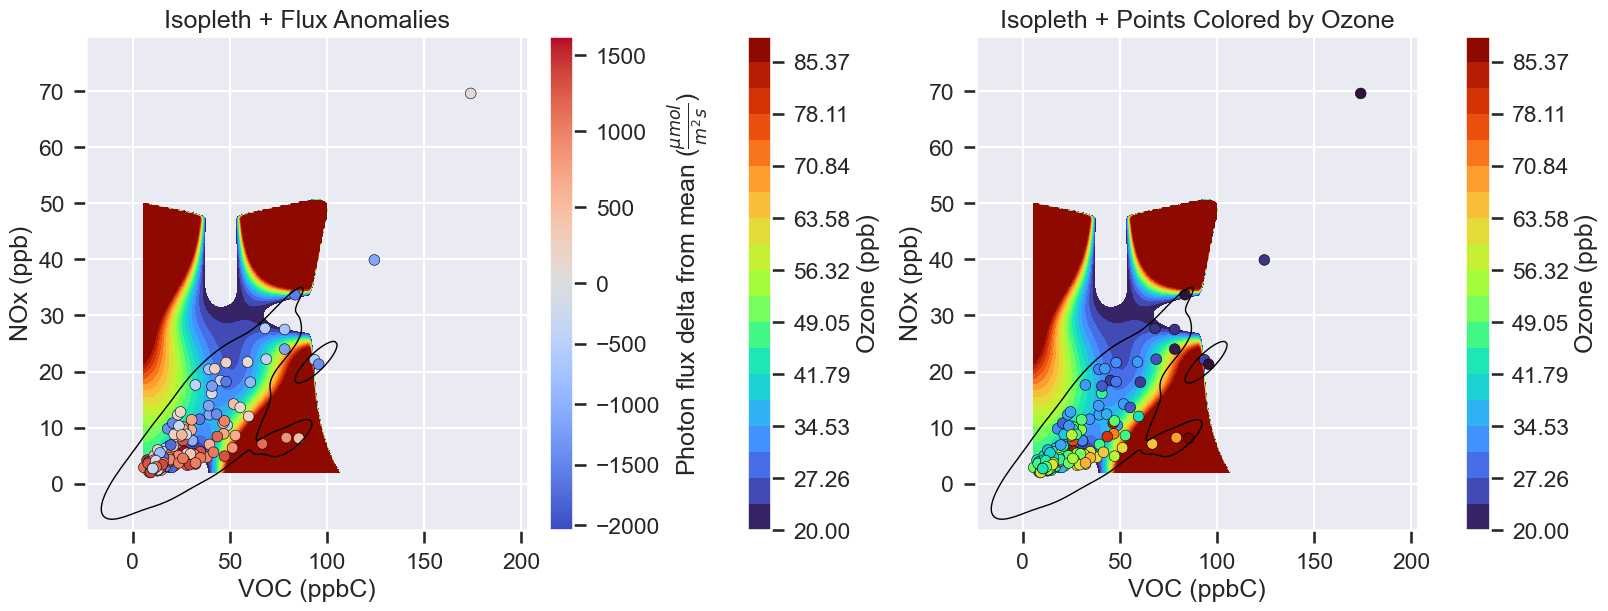

In [41]:
def plot_isopleth_with_flux(data: pd.DataFrame) -> None:
    x = data['VOC'].astype(float)
    y = data['NOx'].astype(float)
    z = data['Ozone'].astype(float)
    delta = data['flux_delta'].astype(float)

    knot_x = np.linspace(x.min(), x.max(), 4)[1:-1]
    knot_y = np.linspace(y.min(), y.max(), 3)[1:-1]

    print(f'[INFO] Knots: {knot_x}, {knot_y}')

    spline = LSQBivariateSpline(x, y, z, knot_x, knot_y,eps=2.002002002101761e-12)

    grid_x = np.linspace(x.min(), x.max(), 200)
    grid_y = np.linspace(y.min(), y.max(), 200)
    X, Y = np.meshgrid(grid_x, grid_y)
    Z = spline(grid_x, grid_y)
    ozone_max = z.max()
    ozone_min = z.min()
    # Limit the spline output so it never exceeds the observed max ozone
    Z = np.clip(Z, None, ozone_max)
    # Use levels based on observed data range to avoid plotting beyond data
    contour_levels = np.linspace(ozone_min, ozone_max, 20)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)

    # LEFT: existing behavior — scatter colored by photon flux delta
    contour0 = axes[0].contourf(X, Y, Z, levels=contour_levels, cmap='turbo')
    fig.colorbar(contour0, ax=axes[0], pad=0.08, label='Ozone (ppb)')

    norm_delta = TwoSlopeNorm(vmin=delta.min(), vcenter=0, vmax=delta.max())
    scatter0 = axes[0].scatter(
        x, y, c=delta, cmap='coolwarm', norm=norm_delta,
        edgecolor='black', linewidth=0.4, s=60
    )
    fig.colorbar(scatter0, ax=axes[0], pad=0.02,
                 label='Photon flux delta from mean ($\\frac{\\mu mol}{m^{2} s}$)')

    sns.kdeplot(data=data, x='VOC', y='NOx', ax=axes[0], levels=2,
                color='black', linewidths=1.0, fill=False)

    axes[0].set_xlabel('VOC (ppbC)')
    axes[0].set_ylabel('NOx (ppb)')
    axes[0].set_title('Isopleth + Flux Anomalies')

    # RIGHT: scatter colored by ozone values
    contour1 = axes[1].contourf(X, Y, Z, levels=contour_levels, cmap='turbo')
    # Remove the separate scatter1 colorbar line
    scatter1 = axes[1].scatter(
        x, y, c=z, cmap='turbo', vmin=ozone_min, vmax=ozone_max,
        edgecolor='black', linewidth=0.4, s=60
    )
    # Keep only the contour1 colorbar labeled 'Ozone (ppb)'
    fig.colorbar(contour1, ax=axes[1], pad=0.08, label='Ozone (ppb)')

    sns.kdeplot(data=data, x='VOC', y='NOx', ax=axes[1], levels=2,
                color='black', linewidths=1.0, fill=False)

    axes[1].set_xlabel('VOC (ppbC)')
    axes[1].set_ylabel('NOx (ppb)')
    axes[1].set_title('Isopleth + Points Colored by Ozone')

    plt.show()

plot_isopleth_with_flux(merged_df.dropna(subset=['flux_delta']))